<a href="https://colab.research.google.com/github/x1001000/books-chinese-networkx/blob/main/Co_occurrence_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 下載博客來中文書各分類 csv 檔
! git clone https://github.com/x1001000/books-chinese-networkx

Cloning into 'books-chinese-networkx'...
remote: Enumerating objects: 965, done.
remote: Total 965 (delta 0), reused 0 (delta 0), pack-reused 965
Receiving objects: 100% (965/965), 65.27 MiB | 6.77 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Checking out files: 100% (963/963), done.


In [ ]:
# 解決 networkx 繪圖無法顯示中文問題
! wget https://github.com/googlefonts/noto-cjk/raw/master/NotoSansCJK-Regular.ttc
! cp NotoSansCJK-Regular.ttc /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf

--2020-10-28 13:12:04--  https://github.com/googlefonts/noto-cjk/raw/master/NotoSansCJK-Regular.ttc
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/googlefonts/noto-cjk/master/NotoSansCJK-Regular.ttc [following]
--2020-10-28 13:12:05--  https://raw.githubusercontent.com/googlefonts/noto-cjk/master/NotoSansCJK-Regular.ttc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20332392 (19M) [application/octet-stream]
Saving to: ‘NotoSansCJK-Regular.ttc’

NotoSansCJK-Regular 100%[===================>]  19.39M  27.7MB/s    in 0.7s    

2020-10-28 13:12:08 (27.7 MB/s) - ‘NotoSansCJK-Regular.ttc’ saved [20332392

In [ ]:
# 安裝 CKIP 套件
! pip install ckiptagger
# 下載 CKIP 模型
from ckiptagger import data_utils
data_utils.download_data_gdown("./")

Downloading...
From: https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
To: /content/data.zip
1.88GB [00:18, 100MB/s] 


In [ ]:
# 匯入斷詞、詞性標記、命名實體識別的三個工具
from ckiptagger import WS, POS, NER
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

In [ ]:
# 匯入所需的 Python 套件
import re
import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy.spatial import distance
import networkx as nx

In [ ]:
#@title 輸入
出版年 = 2020 #@param {type:"integer"}
分類細項 = "\u6587\u5B78\u5C0F\u8AAA>\u7FFB\u8B6F\u6587\u5B78>\u65E5\u672C\u6587\u5B78" #@param {type:"string"}
分類細項 = 分類細項.replace('>', '_')
字詞出現次數大於 = 5 #@param {type:"integer"}

In [ ]:
books = pd.read_csv(f'books-chinese-networkx/博客來-中文書_{分類細項}.csv')
books['出版年'] = pd.Series(int(date[:4]) for date in books['出版日期'])
books[books['出版年']==出版年][['書名', '出版年']]

,書名,出版年
0,﹝新譯﹞宮本百合子的自由之心：收錄〈乳房〉、〈人類的婚姻〉等各種勇於做自己的冒險,2020
1,Days of My Past：512首詩，重返金子美鈴的純真年代【全詩集線裝手札】,2020
2,金色夜叉(三島由紀夫讚譽劃時代之作‧十九世紀末日本最暢銷「國民小說」‧全新中譯本),2020
3,Days of My Past：512首詩，重返金子美鈴的純真年代【全詩集線裝手札】(紀念鉛...,2020
4,那一天，我遇見可以實現願望的神明大人,2020
...,...,...
225,蹺蹺板怪物,2020
226,地下街的雨,2020
227,半邊藍天1,2020
228,金子美鈴詩選,2020


In [ ]:
# 書名中的空白保留，符號與的之移除
titles = []
for title in books[books['出版年']==出版年]['書名']:
    titles.append(re.sub(r'[….。‧、，+：!！?？()（）﹝﹞【】〈〉《》「」『』的之]', '', title))
# 書名分詞，不留單一空白分詞
titles = ws(titles)
for title in titles:
    while ' ' in title:
        title.remove(' ')
len(titles)

230

In [ ]:
# 字詞出現次數
term_count = {}
for title in titles:
    for term in title:
        if term not in term_count:
            term_count[term] = 1
        else:
            term_count[term] += 1
term_count_df = pd.DataFrame({'字詞': [k for k in term_count.keys()], '出現次數': [v for v in term_count.values()]})
term_count_df

,字詞,出現次數
0,新譯,2
1,宮本百合子,1
2,自由心,1
3,收錄,2
4,乳房,1
...,...,...
939,蹺蹺板,1
940,地下街,1
941,詩選,1
942,雙視覺,1


In [ ]:
# 統計
term_count_df[['出現次數']].describe()

,出現次數
count,944.000000
mean,1.752119
std,1.832890
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,17.000000


In [ ]:
df = term_count_df[term_count_df['出現次數'] > 字詞出現次數大於].sort_values(by='出現次數', ascending=False)
len(df)

45

In [ ]:
fig = px.bar(df, color='出現次數', color_continuous_scale=px.colors.sequential.Viridis, x='字詞', y='出現次數')
fig.show()

In [ ]:
vocab    = dict(zip(df['字詞'], range(len(df))))
re_vocab = dict(zip(range(len(df)), df['字詞']))#list(df['字詞'])
len(df) == len(vocab) == len(re_vocab)

True

In [ ]:
combinations_titles = [list(itertools.combinations(title, 2)) for title in titles]
cooccurrence_matrix = np.zeros((len(df), len(df)))
for combinations_title in combinations_titles:
    for comb in combinations_title:
        if comb[0] in vocab.keys() and comb[1] in vocab.keys():
            cooccurrence_matrix[vocab[comb[0]], vocab[comb[1]]] += 1
            cooccurrence_matrix[vocab[comb[1]], vocab[comb[0]]] += 1
for i in range(len(df)):
    cooccurrence_matrix[i, i] /= 2
cooccurrence_matrix

array([[0., 4., 0., ..., 3., 0., 2.],
       [4., 2., 0., ..., 4., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       ...,
       [3., 4., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [2., 0., 1., ..., 0., 0., 0.]])

In [ ]:
jaccard_matrix = 1 - distance.cdist(cooccurrence_matrix, cooccurrence_matrix, 'jaccard')
jaccard_matrix

array([[1.        , 0.11111111, 0.16666667, ..., 0.05      , 0.        ,
        0.13636364],
       [0.11111111, 1.        , 0.11111111, ..., 0.04      , 0.08333333,
        0.07407407],
       [0.16666667, 0.11111111, 1.        , ..., 0.1       , 0.        ,
        0.04545455],
       ...,
       [0.05      , 0.04      , 0.1       , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.08333333, 0.        , ..., 0.        , 1.        ,
        0.13333333],
       [0.13636364, 0.07407407, 0.04545455, ..., 0.        , 0.13333333,
        1.        ]])

In [ ]:
pairs = []
for i in range(len(df)):
    for j in range(i+1, len(df)):
        jaccard = jaccard_matrix[i, j]
        if jaccard > 0:
            pairs.append([re_vocab[i], re_vocab[j], term_count[re_vocab[i]], term_count[re_vocab[j]], jaccard])
len(pairs)

589

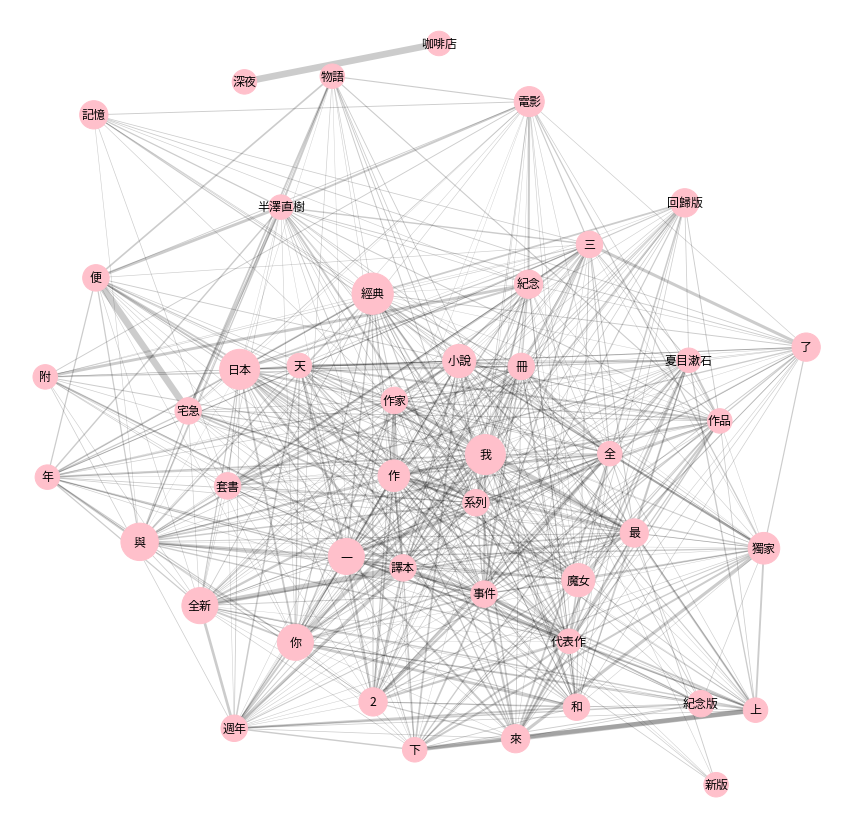

In [ ]:
G = nx.Graph()
#G.nodes(data=True)

for pair in pairs:
    node_x, node_y, node_x_cnt, node_y_cnt, jaccard = pair#[0], pair[1], pair[2], pair[3], pair[4]
    if not G.has_node(node_x):
        G.add_node(node_x, count=node_x_cnt)
    if not G.has_node(node_y):
        G.add_node(node_y, count=node_y_cnt)
    if not G.has_edge(node_x, node_y):
        G.add_edge(node_x, node_y, weight=jaccard)
        
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G, k=1)

node_size = [d['count']*100 for (n,d) in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_color='pink', alpha=1.0, node_size=node_size)
nx.draw_networkx_labels(G, pos)#, fontsize=14, font_family='Droid Sans Japanese')

edge_width = [d['weight']*10 for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='black', width=edge_width)

plt.axis('off')
plt.show()